<a href="https://colab.research.google.com/github/ankp6737/machinelearning/blob/main/Multivariate_Time_Series_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Dataset


Let's read in the data set

In [10]:
import pandas as pd   #import library that helps in data manipulation and analysis. This library will be referred as pd in future program
import numpy as np    #import  library that is used for working with arrays
%matplotlib inline   
import matplotlib.pyplot as plt   #import library for plotting graphs

df = pd.read_csv('/content/drive/MyDrive/Data/energydata_complete.csv',index_col='date', infer_datetime_format=True) #reading the dataset by specifying the path where the dataset is located
df.head()   #to return top rows of the dataset

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [11]:
df.info()   #returns concise summary of the dataframe. 

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9           19735 

# Visulizing the Data

Since it is a multivariate data set visualizing the dataset for each feature one by one

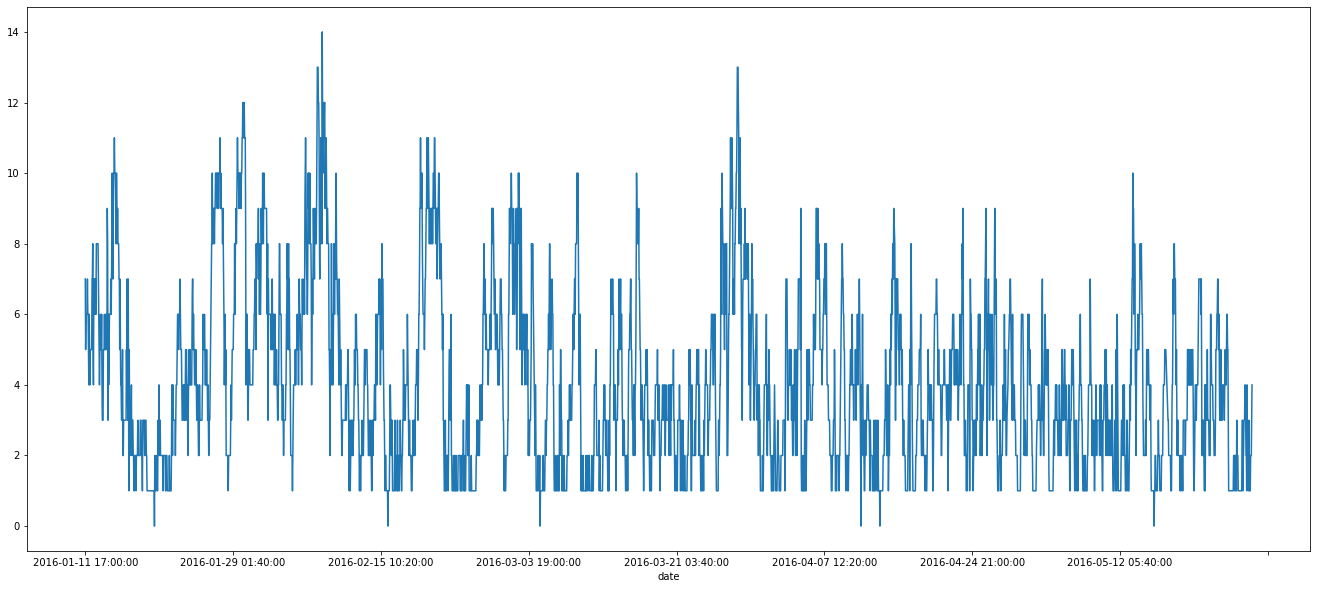

In [12]:
df['Windspeed'].plot(figsize=(23,10))     #

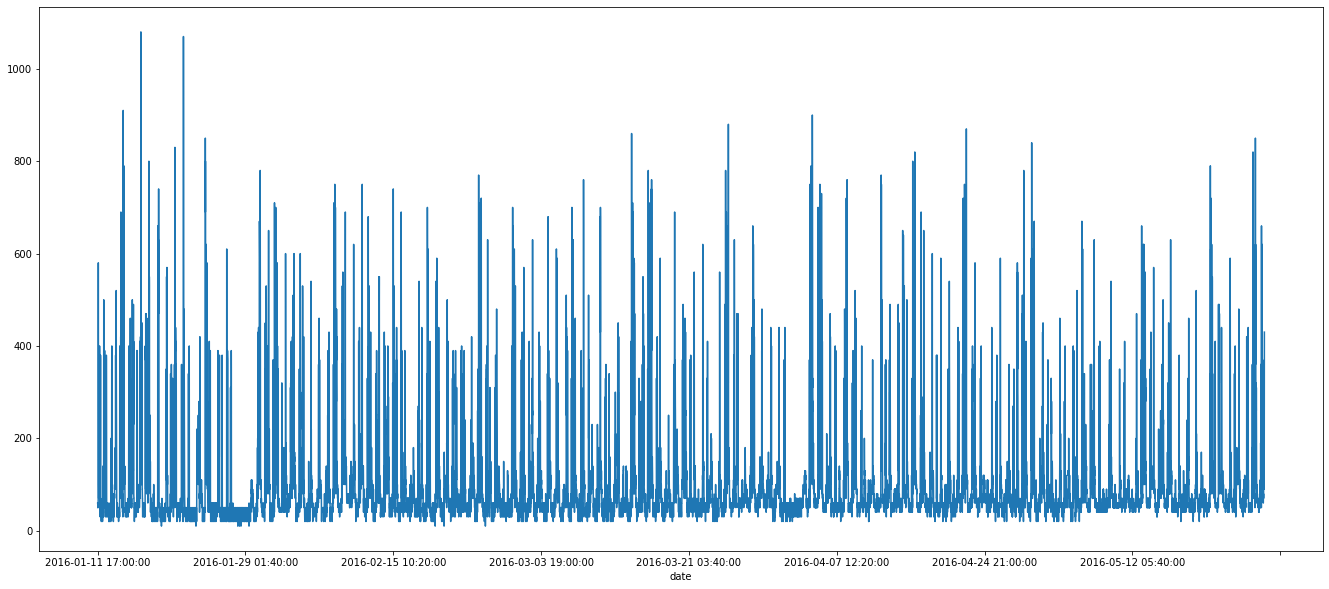

In [13]:
df['Appliances'].plot(figsize=(23,10))

# Splitting the data

Splitting the data into training and test data

In [14]:
df = df.loc['2016-05-01':]
df = df.round(2)

print('len(df)',len(df))
test_days = 2
test_ind = test_days*144 # 24*60/10 = 144
test_ind

len(df) 3853


288

In [15]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

#Scale the Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#Time Series Generator

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# define generator
length = 144 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [19]:
print('len(scaled_train)',len(scaled_train))
print('len(generator) ',len(generator))

X,y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

len(scaled_train) 3565
len(generator)  3421
Given the Array: 
[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
Predict this y: 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


#Define the Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

scaled_train.shape

(3565, 28)

In [21]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


#Earlystopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3421/3421 [==============================] - 135s 39ms/step - loss: 0.0208 - val_loss: 0.0101
Epoch 2/10
3421/3421 [==============================] - 134s 39ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 3/10
3421/3421 [==============================] - 134s 39ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 4/10
3421/3421 [==============================] - 133s 39ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 5/10
3421/3421 [==============================] - 133s 39ms/step - loss: 0.0072 - val_loss: 0.0080
Epoch 6/10
3421/3421 [==============================] - 133s 39ms/step - loss: 0.0073 - val_loss: 0.0082


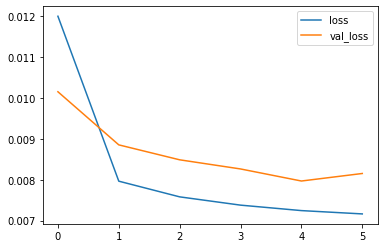

In [23]:
model.history.history.keys()

losses = pd.DataFrame(model.history.history)
losses.plot()

#Evaluate on Test Data

In [24]:
first_eval_batch = scaled_train[-length:]
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [25]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))
model.predict(first_eval_batch)

array([[ 0.07932737,  0.06286785,  0.70454264,  0.3652722 ,  0.5331755 ,
         0.43589985,  0.40944028,  0.4103731 ,  0.6914698 ,  0.397788  ,
         0.3008042 ,  0.36552975,  0.6457164 , -0.00358127,  0.59279513,
         0.40933937,  0.5086731 ,  0.31331903,  0.52858806,  0.35421008,
         0.62933946,  0.526472  ,  0.43508244,  0.20084223,  0.59774697,
         0.54390436,  0.44620645,  0.44122073]], dtype=float32)

In [26]:
scaled_test[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

In [27]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

#Inverse Transformations and Compare

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,81.082073,1.886036,24.525665,37.119776,24.038699,35.119312,25.023404,36.534259,24.040289,37.487247,21.157340,51.433774,18.724344,0.793039,23.161782,34.946976,24.345911,38.746261,21.954376,37.532817,17.055883,756.103561,57.066265,2.008422,40.864818,7.791984,22.306936,22.057800
1,61.931865,2.546535,24.502651,36.814128,23.862262,35.208294,24.942787,36.287278,23.933157,37.241993,21.197155,51.380278,18.324159,0.790056,23.119720,35.174686,24.296930,38.696310,21.912261,37.548140,17.108676,756.137493,57.980455,2.099550,41.595809,7.984166,22.303481,21.928921
2,53.739832,3.023812,24.469753,36.548403,23.667362,35.310403,24.860921,36.062692,23.840943,37.048192,21.217928,51.455331,17.913759,1.010755,23.095383,35.410746,24.247833,38.717204,21.861768,37.556427,17.076372,756.230406,58.776180,2.171178,42.251931,8.162762,22.234030,21.850725
3,49.527823,3.348814,24.429473,36.334587,23.448218,35.428655,24.778444,35.859259,23.757518,36.894279,21.226767,51.532234,17.481666,1.358619,23.077073,35.634443,24.195947,38.765998,21.809646,37.572395,16.988412,756.321281,59.586273,2.226962,42.811136,8.314423,22.115199,21.743400
4,46.811536,3.582055,24.386649,36.173584,23.220993,35.579783,24.697999,35.677219,23.683493,36.766671,21.227534,51.589936,17.045096,1.813490,23.063561,35.846663,24.141827,38.824511,21.760183,37.601922,16.863085,756.427758,60.442040,2.270425,43.298690,8.444769,22.006280,21.643162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,578.554398,-17.667063,25.207199,5.180924,-4.341622,9.091733,7.484538,33.928967,6.529520,-70.074386,17.336904,84.734935,-23.692946,206.425749,29.793444,7.032878,11.496477,55.972886,16.436832,-13.481912,-24.588231,761.323059,151.073381,2.810902,-198.850803,-16.952252,-11.286763,-1.644208
284,578.599513,-17.667933,25.207547,5.180250,-4.340235,9.089272,7.483946,33.928438,6.529642,-70.076582,17.336188,84.736486,-23.694088,206.433837,29.794018,7.032730,11.495879,55.972186,16.437229,-13.483758,-24.587125,761.316166,151.070455,2.811164,-198.853550,-16.951144,-11.288396,-1.643623
285,578.643573,-17.668794,25.207887,5.179599,-4.338885,9.086852,7.483365,33.927939,6.529772,-70.078726,17.335483,84.737924,-23.695208,206.441718,29.794583,7.032563,11.495296,55.971478,16.437618,-13.485573,-24.586052,761.309428,151.067592,2.811420,-198.856125,-16.950066,-11.289996,-1.643039
286,578.686807,-17.669631,25.208219,5.178948,-4.337562,9.084489,7.482803,33.927464,6.529899,-70.080797,17.334796,84.739298,-23.696293,206.449530,29.795138,7.032384,11.494728,55.970806,16.438002,-13.487342,-24.584979,761.302845,151.064720,2.811670,-198.858585,-16.949027,-11.291543,-1.642468


In [29]:
pldf=df.Appliances